In [1]:
!cp /kaggle/input/nn-utils/* .

In [2]:
import threading
import queue
import time
start_time = time.time()
import os
from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
from collections import deque
import numpy as np
from tqdm import tqdm
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

start_time = time.time()

E0000 00:00:1743793478.691622      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [3]:


train_data = []

data_dirs = [
    "/kaggle/input/nn-v1-dataprep-nq2",
    "/kaggle/input/nn-v1-dataprep-es2",
    "/kaggle/input/nn-v1-dataprep-ym2",
    "/kaggle/input/nn-v1-dataprep-eu2",
    "/kaggle/input/nn-v1-dataprep-gb2",
]
data_files= []
for d in data_dirs:
    subfiles = os.listdir(d)
    for f in subfiles:
        if "_train_" in f:
            data_files.append(os.path.join(d,f))


data_index = 0
def load_new_data():
    global data_index
    data_index+=1
    if data_index >= len(data_files):
        data_index = 0

    file = data_files[data_index]
    data = obj_load(file)
    return data
    

data_queue = queue.Queue(maxsize=1)

def data_loader():
    """Background thread that continuously loads data into the queue."""
    while True:
        # Only load new data if there is room in the queue.
        if data_queue.qsize() < data_queue.maxsize:
            new_data = load_new_data()
            print("new data loaded!")
            data_queue.put(new_data)
        else:
            # Sleep briefly to avoid busy waiting.
            time.sleep(1)

# Start the data loader thread as a daemon so it exits when the main program ends.
if False:
    loader_thread = threading.Thread(target=data_loader, daemon=True)
    loader_thread.daemon = True
    loader_thread.start()

# or load all data at once if it fits in memory
if True:
    train_data=[]
    for d in data_dirs:
        subfiles = os.listdir(d)
        for f in subfiles:
            if "_train_" in f:
                    data = obj_load(os.path.join(d,f))
                    train_data.extend(data)
                    #break
        #break

   # info about class distribution
    c0 = 0
    c1 = 0
    c2 = 0
    print("info about y distribution:")
    for x,y in train_data:
            if y == -1:
                c0+=1
            if y == 1:
                c1+=1
            if y == 0:
                c2+=1
    print("raw distribution:", c0,c1,c2)
    
    l = len(train_data)
    print("relative distribution:", c0/l,c1/l,c2/l)

loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_2


loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_3


loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_1


loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_0


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_0


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_1


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_3


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_2


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_0


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_3


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_2


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_1


loading /kaggle/input/nn-v1-dataprep-eu2/EURUSD_2_train_0


loading /kaggle/input/nn-v1-dataprep-eu2/EURUSD_2_train_1


loading /kaggle/input/nn-v1-dataprep-gb2/GBPUSD_2_train_0


loading /kaggle/input/nn-v1-dataprep-gb2/GBPUSD_2_train_1


info about y distribution:


raw distribution: 1454111 1372224 11281837
relative distribution: 0.10306870372717315 0.09726447905511784 0.799666817217709


In [4]:
if True:
    try:
        cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
        tf.config.experimental_connect_to_cluster(cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
        strategy = tf.distribute.TPUStrategy(cluster_resolver)
        print("use tpu strategy")
    except:
        strategy = tf.distribute.MirroredStrategy()
    strategy

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1743794073.324891      74 service.cc:148] XLA service 0x5bbdf65ca8d0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743794073.324936      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1743794073.324942      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1743794073.324945      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1743794073.324948      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1743794073.324950      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1743794073.324953      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1743794073.324956      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1743794073.324971      74 service.cc:156]   StreamExecutor de

vice (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


use tpu strategy


In [5]:
with strategy.scope():
#if True:
        
    lrelu = tf.keras.layers.LeakyReLU(0.05)
    
    
    chart_m15 = tf.keras.layers.Input(shape = (60,4))
    chart_m15 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m15)

    chart_m5 = tf.keras.layers.Input(shape = (60,4))
    chart_m5 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m5)
    
    chart_m1 = tf.keras.layers.Input(shape = (60,4))
    chart_m1 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m1)
    
    pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))
    
    pdas_repeated = tf.keras.layers.Lambda(
    lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
    )(pdas)
    
    concatenated_m15_at = tf.keras.layers.Concatenate(axis=-1)([chart_m15, pdas_repeated])
    m15_at = tf.keras.layers.Dense(1024)(concatenated_m15_at)
    m15_at = lrelu(m15_at)
    m15_at = tf.keras.layers.Dense(512)(m15_at)
    m15_at = lrelu(m15_at)
    m15_at = tf.keras.layers.Dense(512)(m15_at)
    m15_at = lrelu(m15_at)
    m15_at = tf.keras.layers.Dense(512)(m15_at)
    m15_at = tf.keras.layers.LayerNormalization()(m15_at)
    m15_at = lrelu(m15_at)
    m15_at = tf.keras.layers.LSTM(1024, return_sequences=True)(m15_at)
    m15_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m15_at)
    
    concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
    m5_at = tf.keras.layers.Dense(1024)(concatenated_m5_at)
    m5_at = lrelu(m5_at)
    m5_at = tf.keras.layers.Dense(512)(m5_at)
    m5_at = lrelu(m5_at)
    m5_at = tf.keras.layers.Dense(512)(m5_at)
    m5_at = lrelu(m5_at)
    m5_at = tf.keras.layers.Dense(512)(m5_at)
    m5_at = tf.keras.layers.LayerNormalization()(m5_at)
    m5_at = lrelu(m5_at)
    m5_at = tf.keras.layers.LSTM(1024, return_sequences=True)(m5_at)
    m5_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m5_at)
    
    concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
    m1_at = tf.keras.layers.Dense(1024)(concatenated_m1_at)
    m1_at = lrelu(m1_at)
    m1_at = tf.keras.layers.Dense(512)(m1_at)
    m1_at = lrelu(m1_at)
    m1_at = tf.keras.layers.Dense(512)(m1_at)
    m1_at = lrelu(m1_at)
    m1_at = tf.keras.layers.Dense(512)(m1_at)
    m1_at = tf.keras.layers.LayerNormalization()(m1_at)
    m1_at = lrelu(m1_at)
    m1_at = tf.keras.layers.LSTM(1024, return_sequences=True)(m1_at)
    m1_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m1_at)
    
    minutes = tf.keras.layers.Input(shape = (1,))
    minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
    minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)
    
    f15 = tf.keras.layers.Flatten()(chart_m15)
    f5 = tf.keras.layers.Flatten()(chart_m5)
    f1 = tf.keras.layers.Flatten()(chart_m1)
    
    #c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
    c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])
    #c = tf.keras.layers.Concatenate()([f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])
    
    
    d = tf.keras.layers.Dense(4096*4)(c)
    d = tf.keras.layers.LayerNormalization()(d)
    d = lrelu(d)
    d = tf.keras.layers.Dropout(0.05)(d)
    
    d = tf.keras.layers.Dense(4096*4)(d)
    d = tf.keras.layers.LayerNormalization()(d)
    d = lrelu(d)
    d = tf.keras.layers.Dropout(0.05)(d)
    
    d = tf.keras.layers.Dense(4096*2)(d)
    d = tf.keras.layers.LayerNormalization()(d)
    d = lrelu(d)
    d = tf.keras.layers.Dropout(0.05)(d)
    
    d = tf.keras.layers.Dense(4096*2)(d)
    d = tf.keras.layers.LayerNormalization()(d)
    d = lrelu(d)
    d = tf.keras.layers.Dropout(0.05)(d)
    
    
    
    
    output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)
    
    model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, clipnorm=1.0)
    
    
model.summary()

I0000 00:00:1743794078.336885      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 94)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_11CLO… │ (None, 60, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 60, 94)    │          0 │ input_layer_3[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 60, 98)    │          0 │ keras_tensor_11C… │
│ (Concatenate)       │                   │            │ lambda_3[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 60, 1024)  │    101,376 │ concatenate_2[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8192)      │          0 │ dense_8[1][0],    │
│ (LeakyReLU)         │                   │            │ dense_9[1][0],    │
│                     │                   │            │ dense_10[1][0],   │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ dense_4[1][0],    │
│                     │                   │            │ dense_5[1][0],    │
│                     │                   │            │ dense_6[1][0],    │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ dense[1][0],      │
│                     │                   │            │ dense_1[1][0],    │
│                     │                   │            │ dense_2[1][0],    │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 60, 512)   │    524,800 │ leaky_re_lu[16][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 60, 512)   │    262,656 │ leaky_re_lu[17][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_7CLONE │ (None, 60, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 60, 512)   │    262,656 │ leaky_re_lu[18][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 60, 98)    │          0 │ keras_tensor_7CL… │
│ (Concatenate)       │                   │            │ lambda_3[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 512)   │      1,024 │ dense_11[1][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 60, 1024)  │    101,376 │ concatenate_1[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 60, 512)   │    524,800 │ leaky_re_lu[20][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 581,267,203 (2.17 GB)

 Trainable params: 581,267,203 (2.17 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

 
class_counts = np.array([c0, c1, c2])
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
print("weights:", class_weights_tensor)


tf.function(jit_compile=True) # my gpu does not support this
def tstep(data):
    x, y = data

    with tf.GradientTape() as t:
        model_return = model(x, training=True)
        #print(y, model_return)
        loss = loss_fn(y, model_return)
        #print(loss)
        

        # Apply class weights
        sample_weights = tf.reduce_sum(y * class_weights_tensor, axis=-1)  # Select the correct weight for each sample
        loss = loss * sample_weights  # Multiply loss by sample weights

        loss = tf.reduce_mean(loss)

        
        #if loss > 10:
        #    loss *= 0.1  # Scale down the loss if it's greater than 10, probably data point error

    predicted_class = tf.argmax(model_return, axis=-1)
    true_class = tf.argmax(y, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_class, true_class), tf.float32))
            
    
    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss, accuracy


batch_size = 128

def get_data(_):
    global train_data

    while len(train_data) < 10000:
        if not data_queue.empty():
            new_data = data_queue.get(timeout=1)  # wait up to 1 second for data
            train_data.extend(new_data)
        else:
            # If no new data is available, break out of the loop.
            print("waiting for data....")
            time.sleep(1)
            continue
    
    # Pop a batch of data from the front.
    train_sample = train_data[:batch_size]
    train_data = train_data[batch_size:]

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)





train_index = 0
def get_data_2(_):
    global train_index
    train_sample = [train_data[i] for i in range(train_index, train_index + batch_size)]
    train_index += batch_size
    if train_index + batch_size >= len(train_data):
        train_index = 0

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)


weights: tf.Tensor([3.2340887  3.4270818  0.41684029], shape=(3,), dtype=float32)


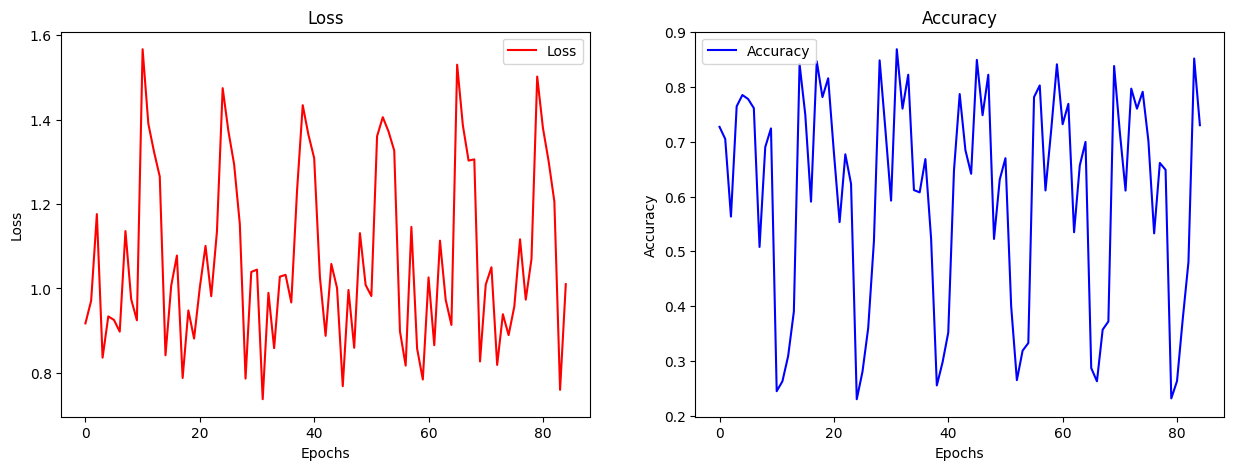

84 1.0101287 0.7302344


In [7]:
@tf.function(reduce_retracing=True)
def run(data):
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, strategy.run(tstep, args = (data,)), axis = None)

import IPython

loss_lt = []
acc_lt = []

for n in range(500):
    losses_st = []
    acc_st = []
    #for _ in tqdm(range(1000)):
    for _ in range(1000):
        #distributed_data = (strategy.experimental_distribute_values_from_function(get_data))
        distributed_data = (strategy.experimental_distribute_values_from_function(get_data_2))
        loss, acc = run(distributed_data)
        
        #data = get_data(None)
        #loss = tstep(data)
        losses_st.append(loss)
        acc_st.append(acc)
    
    loss_lt.append(np.mean(losses_st))
    acc_lt.append(np.mean(acc_st))

    
    IPython.display.clear_output()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(loss_lt, label="Loss", color="red")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot Accuracy
    ax2.plot(acc_lt, label="Accuracy", color="blue")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()
    #print(loss_lt, acc_lt)
    print(n, loss_lt[-1], acc_lt[-1])

    if time.time() - start_time > 60*60*8.5:
        break


In [8]:
model.save_weights("model.weights.h5")

In [9]:
#model.load_weights("model.weights.h5")